Could try and answer two questions:
 
 1.Can I predict is a loan will be defaulted on?
 
 2. If a loan defaults, how much can be expected to be lost?
 
 Will need to handle imbalance of franchised and not franchised

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import LeaveOneOutEncoder

# Replace with whatever model import(s) you're using
from xgboost import XGBClassifier


%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
data = pd.read_csv("data/SBAnational.csv")

C:\Users\dgump\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<IPython.core.display.Javascript object>

##### Original Column Appendix
  0. [ ] `City`: May drop, useful for identifying missing states
  2. [ ] `State`: May be good predictor. Check for strange values
  3. [X] `Bank`: Lots of names. Can id which banks give the most loans and make new feature `is_big_bank`. Uncertain of predicitive strength as is arbitrarily nominal.
     * [X] Create `is_big_bank` column
 
4. [X] `BankState`: Doubtful of individual predicitive power. Can make new feature `out_of_state_bank`
   * [X] Create `out_of_state_bank` binary column
5. [X] `NAICS`: Extracted relevant 2 digit code. Needs categorical encoding.
    * Will try traget encoding
6. [X] `ApprovalDate`: Needs cleaned. Relevancy will depend on how time is considered
    * Converted to pd datetime. Can use for final selection after data cleaning
7. [X] `ApprovalFY`: Approval Fiscal Year. Same as 6.
8. [X] `Term`: Length of loan in months
    * Converted to years
9. [X] `NoEmp`: Number of business employees. Maybe code into tiers?
     * Already very clean, skewed
10. [X] `NewExist`: 1 = existing business, 2 = new business. Make 0,1 style binary
11. [X] `CreateJob`: Number of jobs created. Maybe code into tiers?
12. [X] `RetainedJob`: Number of jobs retained. Maybe code into tiers?
13. [X] `UrbanRural`: 1 = Urban, 2 = rural, 0 = undefined. Needs cleaned
    * Clean, need to decide on how to handle Nan's. Knn impute?
14. [X] `RevLineCr`: Revolving Line of credit, y/n. Many nonsensical inputs. Cleaned
15. [X] `LowDoc`: LowDoc loan program. y/n. Needs investigation
    * Cleaned to 0,1. Handle nan's. Knn imputer?
16. [X] `ChgOffDate`: Date loan charged off. Irrelevant given MIS_status. Could be considered in relation to how long default was before end of term.
    * Attend to if doing follow up regression
17. [X] `DisbursementDate`: as name implies. Consider redundancy with `ApprovalDate` and `ApprovalFY`
    * engineered feature to indicate if SBA committed before or after the loan was disbursed
18. [X] `DisbursementGross`: amount of loan. 
    * Clean, some errant values. Possibly use for selection
19. [X] `BalanceGross`: Gross amount outstanding. Unsure if at time of default, or implying some of these loans have yet to be finished. May want to only consider final loans to model predicitions.
    * Clean. Mostly zero, suggesting class imbalance
20. [X] `MIS_Status`: Loan status. Charged off or paid in full. TARGET?!
21. [X] `ChgOffPrinGr`: Charged off amount. Could make for an interesting second regression target.
22. [ ] `GrAppv`: Gross amount approved by bank
23. [X] `SBA_Appv`: SBA's gaurenteed amount of the loan. Mayne %SBA_Appv of loan amount would be predicitive? 

In [4]:
# make a binary column to rep if a loan is form a big bank
# a big bank is one that has over 500 loans in this data set

# big_bank = data["Bank"].value_counts(dropna=False) > 500
# data[data["Bank"].isin(big_bank)]

# data.groupby("BankState")["Bank"].value_counts(dropna=False).head(100)

# # data["Bank"].isna().sum()

<IPython.core.display.Javascript object>

In [5]:
pd.options.display.max_rows = 999
data["ApprovalFY"].value_counts(dropna=False)

data.loc[data["ApprovalFY"] == "1976A", "ApprovalFY"] = "1976"
data["ApprovalFY"] = data["ApprovalFY"].astype(int)
data["ApprovalFY"].value_counts(dropna=False)

2005    77525
2006    76040
2007    71876
2004    68290
2003    58193
1995    45758
2002    44391
1996    40112
2008    39540
1997    37748
2000    37381
1999    37363
2001    37350
1998    36016
1994    31598
1993    23305
1992    20885
2009    19126
2010    16848
1991    15666
1990    14859
1989    13248
2011    12608
2012     5997
2013     2458
1987     2218
1986     2118
1984     2022
1985     1944
1988     1898
1983     1684
1982      719
1981      630
1980      477
1979      352
2014      268
1978      242
1977      137
1976       84
1973       52
1974       42
1975       30
1972       27
1971       20
1970        8
1969        4
1968        2
1967        2
1966        1
1965        1
1962        1
Name: ApprovalFY, dtype: int64

<IPython.core.display.Javascript object>

In [6]:
data["NAICS"].astype(str).str[0:2].value_counts(dropna=False)

data["twoDigNAICS"] = data["NAICS"].astype(str).str[0:2]
data["twoDigNAICS"] = data["twoDigNAICS"].astype(int)
data["twoDigNAICS"].value_counts(dropna=False)

0     201948
44     84737
81     72618
54     68170
72     67600
23     66646
62     55366
42     48743
45     42514
33     38284
56     32685
48     20310
32     17936
71     14640
53     13632
31     11809
51     11379
52      9496
11      9005
61      6425
49      2221
21      1851
22       663
55       257
92       229
Name: twoDigNAICS, dtype: int64

<IPython.core.display.Javascript object>

In [7]:
data.loc[data["FranchiseCode"] > 1, "is_franchise"] = 1
data.loc[data["FranchiseCode"] <= 1, "is_franchise"] = 0
data["is_franchise"].value_counts(dropna=False)

0.0    847389
1.0     51775
Name: is_franchise, dtype: int64

<IPython.core.display.Javascript object>

In [8]:
# TO_DO: Handle NAN's

# some nonsense in here
# data["RevLineCr"].value_counts(dropna=False)

revCR_map = {
    "N": 0,
    "0": 0,
    "Y": 1,
    "T": 1,  # T for true? maybe
}
data["RevLineCr"] = data["RevLineCr"].map(revCR_map)
# data["RevLineCr"] = data["RevLineCr"].astype(int, errors="ignore")
data["RevLineCr"].value_counts(dropna=False)

0.0    677890
1.0    216681
NaN      4593
Name: RevLineCr, dtype: int64

<IPython.core.display.Javascript object>

In [9]:
# clean city column
data["City"].value_counts(dropna=False)

LOS ANGELES                       11558
HOUSTON                           10247
NEW YORK                           7846
CHICAGO                            6036
MIAMI                              5594
                                  ...  
POPLAR BRANCH                         1
CLAIRSSA                              1
MIKADO                                1
MEADOW LANDS                          1
CENTREVILLE (RR NAME CENTERVIL        1
Name: City, Length: 32582, dtype: int64

<IPython.core.display.Javascript object>

In [10]:
# clean state columns
data["State"].isna().sum()
data[data["State"].isna()]

data["State"] = data["State"].fillna(data["BankState"])
data["State"].isna().sum()

# 1 left from 1981, looks like nothing we want
data[data["State"].isna()]

data = data.dropna(subset=["State"])
cleaned_States = list(data["State"].value_counts().sort_index().index)
#cleaned_States


<IPython.core.display.Javascript object>

In [11]:
# clean Bank State
data["BankState"].value_counts().sort_index()

# keep rows where the BankState value appears more than 100 times. Want to match State column
valid_states = list(data["State"].value_counts().index)
bankState_valid = data["BankState"].isin(valid_states)
# only going to lose 1700 rows. Drop em.
cleaned_bankStates = list(
    data.loc[bankState_valid, "BankState"].value_counts().sort_index().index
)

data = data.loc[bankState_valid]

<IPython.core.display.Javascript object>

In [12]:
cleaned_bankStates == cleaned_States


True

<IPython.core.display.Javascript object>

In [13]:
# make column bank_out_of_state

data["bank_out_of_state"] = data["State"] == data["BankState"]
data["bank_out_of_state"] = data["bank_out_of_state"].astype(int)
data["bank_out_of_state"].value_counts(dropna=False)

1    473953
0    423481
Name: bank_out_of_state, dtype: int64

<IPython.core.display.Javascript object>

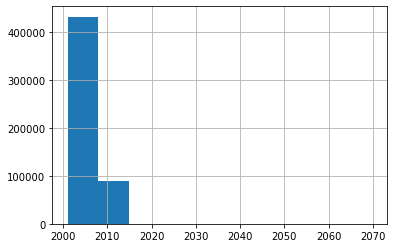

<IPython.core.display.Javascript object>

In [14]:
# Approval Date. No NA's originally
# some are in the future! Handle this. Maybe hit 2 instead of 1?
data["ApprovalDate_datetime"] = pd.to_datetime(data["ApprovalDate"])
data.loc[data["ApprovalDate_datetime"].dt.year > 2000, "ApprovalDate_datetime"].hist()

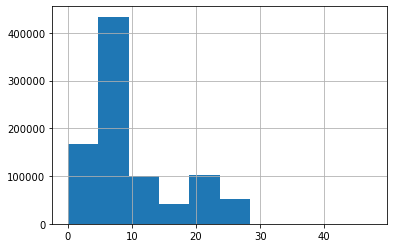

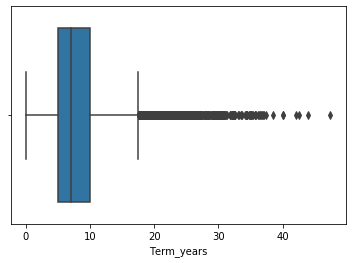

count    897434.000000
mean        110.777526
std          78.863169
min           0.000000
25%          60.000000
50%          84.000000
75%         120.000000
max         569.000000
Name: Term, dtype: float64

<IPython.core.display.Javascript object>

In [15]:
# clean term column. IN months, convert to years
# appears to be some skew.
data["Term"].isna().sum()
data["Term_years"] = data["Term"] / 12
data["Term_years"].hist()
plt.show()
sns.boxplot(data["Term_years"])
plt.show()
data["Term"].describe()

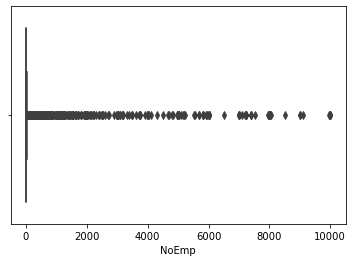

count    897434.000000
mean         11.405530
std          74.171788
min           0.000000
25%           2.000000
50%           4.000000
75%          10.000000
max        9999.000000
Name: NoEmp, dtype: float64

<IPython.core.display.Javascript object>

In [16]:
# clean noemp columns
# lots of skew to consider
data["NoEmp"].isna().sum()
data["NoEmp"].value_counts()
sns.boxplot(data["NoEmp"])
plt.show()
data["NoEmp"].describe()

# # 0, 1-10, 10-100, 100+, bins
# data.loc[data["NoEmp"] == 0, "noemp_category"] = 0


In [17]:
data["NewExist"].value_counts(dropna=False)

1.0    643591
2.0    252677
0.0      1030
NaN       136
Name: NewExist, dtype: int64

<IPython.core.display.Javascript object>

In [18]:
# clean NewExist column. 1 is existing, 2 is new. Handle na's and 0's
# note: some approval dates are in the future!
pd.options.display.max_columns = 999
data["NewExist"].isna().sum
data["NewExist"].value_counts(dropna=False)

data.loc[data["NewExist"].isna(), "ApprovalDate_datetime"].value_counts().sort_index()
data.loc[data["NewExist"].isna(), "bank_out_of_state"].value_counts()
data.loc[data["NewExist"].isna(), "ApprovalDate_datetime"].describe()
# some weirdness with the na's. All but one are from dec-2019 through around 2010.
# just going on a hunch and filling these missing values with 1: an existing business
NewExist_map = {1: 0, 2: 1, 0: 1, np.nan: 1}

data["NewExist"] = data["NewExist"].map(NewExist_map)
data["NewExist"].value_counts()

0    643591
1    253843
Name: NewExist, dtype: int64

<IPython.core.display.Javascript object>

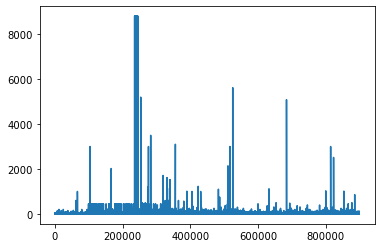

0.0    627540
1.0    228698
2.0     39944
3.0      1252
Name: job_category, dtype: int64

<IPython.core.display.Javascript object>

In [19]:
# made new feature based on how many drops created. Skewed towards zero

data["CreateJob"].isna().sum()
data["CreateJob"].describe()
plt.plot(data["CreateJob"])
plt.show()
data["CreateJob"].value_counts().sort_index()

# 0, 1-10, 10-100, 100+, bins
data.loc[data["CreateJob"] == 0, "job_category"] = 0
data.loc[data["CreateJob"] > 0, "job_category"] = 1
data.loc[data["CreateJob"] > 10, "job_category"] = 2
data.loc[data["CreateJob"] > 100, "job_category"] = 3

data["job_category"].value_counts()

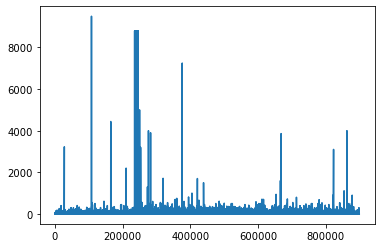

0.0    438700
1.0    368080
2.0     87553
3.0      3101
Name: retained_category, dtype: int64

<IPython.core.display.Javascript object>

In [20]:
# clean retained jobs
data["RetainedJob"].isna().sum()
data["RetainedJob"].value_counts()
plt.plot(data["RetainedJob"])
plt.show()

# let's do a similar treatment as with jobs created. might expect some colinearity?
# 0, 1-10, 10-100, 100+, bins
data.loc[data["RetainedJob"] == 0, "retained_category"] = 0
data.loc[data["RetainedJob"] > 0, "retained_category"] = 1
data.loc[data["RetainedJob"] > 10, "retained_category"] = 2
data.loc[data["RetainedJob"] > 100, "retained_category"] = 3

data["retained_category"].value_counts()

0.0    470632
NaN    321469
1.0    105333
Name: UrbanRural_cleaned, dtype: int64

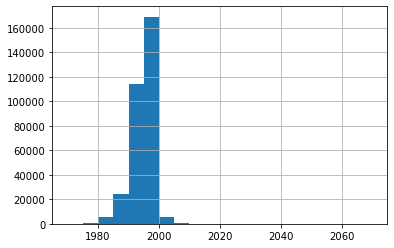

<IPython.core.display.Javascript object>

In [21]:
# clean urban/rural column. 1: urban, 2: rural, 0:undefined
data["UrbanRural"].value_counts()

# investigate na's for patterns, but will definitely remap to 0,1
data.loc[data["UrbanRural"] == 0, "ApprovalDate_datetime"].describe()
# looks lijke undefined (0's) are from mid-late 90's
# clue that future values might need to be 19 not 20
data.loc[data["UrbanRural"] == 0, "ApprovalDate_datetime"].hist(bins=20)
data["UrbanRural"].value_counts()

UrbanRural_map = {1: 0, 2: 1, 0: np.nan}

data["UrbanRural_cleaned"] = data["UrbanRural"].map(UrbanRural_map)
data["UrbanRural_cleaned"].value_counts(dropna=False)

In [22]:
# clean LowDoc. Lot's of Na's
# y = yes, n = no
data["LowDoc"].isna().sum()
data["LowDoc"].value_counts(dropna=False)
# more nonsense, awesome
LowDoc_map = {
    "N": 0,
    "Y": 1,
}
data['LowDoc'] = data["LowDoc"].map(LowDoc_map, na_action="ignore")
data['LowDoc'].value_counts(dropna=False)


0.0    781263
1.0    110166
NaN      6005
Name: LowDoc, dtype: int64

<IPython.core.display.Javascript object>

In [23]:
# clean chrgoffdate
# redundant to target. Use MIS_Status as target

# would be useful to see if time from approval to charge off was predictive for regression,
# but it is illegal information for the classification problem
data["ChgOffDate"].isna().sum()
data["ChgOffDate"].value_counts(dropna=False)

NaN          734902
13-Mar-10       734
20-Feb-10       614
30-Jan-10       519
6-Feb-10        461
              ...  
6-Jan-06          1
8-Jun-91          1
3-Oct-96          1
4-Dec-95          1
1-Dec-02          1
Name: ChgOffDate, Length: 6445, dtype: int64

<IPython.core.display.Javascript object>

In [24]:
data = data.loc[
    data["ApprovalDate_datetime"].dt.year < 2020,
]
data = data.loc[data["ApprovalDate_datetime"].dt.year > 2000]

<IPython.core.display.Javascript object>

In [25]:
data["DisbursementDate"].isna().sum()
data.loc[data["DisbursementDate"].isna()]
data["DisbursementDate"] = data["DisbursementDate"].fillna(data["ApprovalDate"])

data["Disbr_datetime"] = pd.to_datetime(data["DisbursementDate"])

# cuts dout about 300k rows
data = data.loc[data["Disbr_datetime"].dt.year.isin(np.arange(2000, 2020, 1))]
data["Disbr_datetime"].dt.year.describe()
# # note the 2069 jumping out again. Just going to ignore it,
# # because it is from a time we don't care about
data["Disbr_year"] = data["Disbr_datetime"].dt.year
data["Disbr_month"] = data["Disbr_datetime"].dt.month - 1
data["Disbr_Month_sin"] = np.sin((data["Disbr_month"]) * (2.0 * np.pi / 12))
data["Disbr_Month_cos"] = np.cos((data["Disbr_month"]) * (2.0 * np.pi / 12))

<IPython.core.display.Javascript object>

In [26]:
# make a feature identifying if SBA approval was given before or after loan disbursed

data["time_to_disbr"] = data["Disbr_datetime"] - data["ApprovalDate_datetime"]

sba_pre_approved = data["time_to_disbr"] > np.timedelta64(0, "D")
sba_pre_approved.value_counts(dropna=False)
data.loc[sba_pre_approved, "sba_pre_approv"] = 1
data.loc[~sba_pre_approved, "sba_pre_approv"] = 0
data["sba_pre_approv"].value_counts(dropna=False)

1.0    505565
0.0     17017
Name: sba_pre_approv, dtype: int64

<IPython.core.display.Javascript object>

In [27]:
# clean disbursementgross
data["DisbursementGross"].isna().sum()
data["DisbursementGross"] = data["DisbursementGross"].str.replace("$", "")
data["DisbursementGross"] = data["DisbursementGross"].str.replace(",", "")
data["DisbursementGross"] = data["DisbursementGross"].astype(float)


# may want to do some selection on this later`

# data["DisbursementGross"].value_counts().sort_index()
# # 28 rows with 0, some in single digits??
# data.loc[data["DisbursementGross"] < 1000, "DisbursementGross"].describe()
# data["DisbursementGross"].isna().sum()

<IPython.core.display.Javascript object>

In [28]:
# clean balancegross

data["BalanceGross"].isna().sum()
# data["BalanceGross"].value_counts()
data["BalanceGross"] = data["BalanceGross"].str.replace("$", "")
data["BalanceGross"] = data["BalanceGross"].str.replace(",", "")
data["BalanceGross"] = data["BalanceGross"].astype(float)

data["BalanceGross"].value_counts(dropna=False)
# small number have a balance. Chrgd off vs PIF may be severly imbalanced, or this column is trash

0.0         522569
996262.0         1
115820.0         1
827875.0         1
12750.0          1
25000.0          1
395476.0         1
96908.0          1
43127.0          1
84617.0          1
41509.0          1
600.0            1
37100.0          1
9111.0           1
Name: BalanceGross, dtype: int64

<IPython.core.display.Javascript object>

In [29]:
# clean ChgOffPrinGr

data["ChgOffPrinGr"].isna().sum()
data["ChgOffPrinGr"].value_counts()
data["ChgOffPrinGr"] = data["ChgOffPrinGr"].str.replace("$", "")
data["ChgOffPrinGr"] = data["ChgOffPrinGr"].str.replace(",", "")
data["ChgOffPrinGr"] = data["ChgOffPrinGr"].astype(float)

data["ChgOffPrinGr"].value_counts(dropna=False)

0.0         388339
50000.0       2073
10000.0       1852
25000.0       1346
35000.0       1337
             ...  
30686.0          1
122745.0         1
196184.0         1
11817.0          1
62178.0          1
Name: ChgOffPrinGr, Length: 67412, dtype: int64

<IPython.core.display.Javascript object>

In [30]:
# clean SBA_Appv

data["SBA_Appv"].isna().sum()
data["SBA_Appv"].value_counts()

data["SBA_Appv"] = data["SBA_Appv"].str.replace("$", "")
data["SBA_Appv"] = data["SBA_Appv"].str.replace(",", "")
data["SBA_Appv"] = data["SBA_Appv"].astype(float)

data["SBA_Appv"].value_counts(dropna=False)

25000.0     45647
12500.0     37226
5000.0      29166
50000.0     21941
10000.0     15539
            ...  
790125.0        1
48225.0         1
98753.0         1
98736.0         1
32768.0         1
Name: SBA_Appv, Length: 17597, dtype: int64

<IPython.core.display.Javascript object>

In [31]:
data["MIS_Status"].value_counts(dropna=False)

P I F     390973
CHGOFF    129981
NaN         1628
Name: MIS_Status, dtype: int64

<IPython.core.display.Javascript object>

In [32]:
# come back after handling remaining money columns

data["MIS_Status"].isna().sum()
# only 1628 na's here! not bad. Maybe lost more with previous selection? Not an answer I care about
data["MIS_Status"].value_counts(dropna=False)
# about 400K PIF and 120k CHGOFF. I'll investigate the nans for patterns,
# but dropping them will little impact
data.loc[data["MIS_Status"].isna(), "ApprovalFY"].value_counts()
# 2001 - 2013. Seems to just be random from our distribution
data.loc[data["MIS_Status"].isna(), "BalanceGross"].describe()
# all na's have a zero balance
data.loc[data["MIS_Status"].isna(), "ChgOffPrinGr"].describe()
data.loc[data["MIS_Status"].isna(), "ChgOffPrinGr"].value_counts()
# 1463 of th na's have no charge off amount. These will be set to PIF. Remaining to charged off
mis_na_pif = (
    data.loc[data["MIS_Status"].isna()].loc[data["ChgOffPrinGr"] == 0].index.to_list()
)
data.loc[mis_na_pif, "MIS_Status"] = data.loc[mis_na_pif, "MIS_Status"].fillna(
    value="P I F"
)

mis_na_CHGOFF = (
    data.loc[data["MIS_Status"].isna()].loc[data["ChgOffPrinGr"] != 0].index.to_list()
)
data.loc[mis_na_CHGOFF, "MIS_Status"] = data.loc[mis_na_CHGOFF, "MIS_Status"].fillna(
    value="CHGOFF"
)
data["MIS_Status"].value_counts(dropna=False)

MIS_Status_map = {
    'P I F': 0,
    'CHGOFF': 1,
    0: 0,
    1: 1
}

data['MIS_Status'] = data['MIS_Status'].map(MIS_Status_map, na_action='ignore')
data["MIS_Status"].value_counts(dropna=False)


0    392436
1    130146
Name: MIS_Status, dtype: int64

<IPython.core.display.Javascript object>

In [33]:
# could maybe do some target encoding instead?

banks = data["Bank"].value_counts()

big_banks = banks.loc[banks.values >= 1000].index.to_list()

med_banks = banks.loc[banks.values >= 100]
med_banks = med_banks.loc[med_banks.values < 1000]
med_banks = med_banks.index.to_list()

small_banks = banks.loc[banks.values < 100].index.to_list()

data.loc[data["Bank"].isin(small_banks), "bank_size"] = 0
data.loc[data["Bank"].isin(med_banks), "bank_size"] = 1
data.loc[data["Bank"].isin(big_banks), "bank_size"] = 2
data['']

<IPython.core.display.Javascript object>

1    799
Name: Bank, dtype: int64

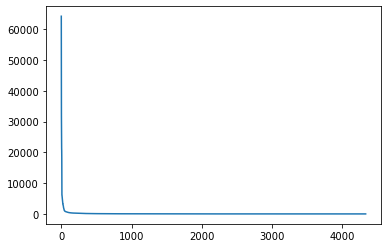

<IPython.core.display.Javascript object>

In [75]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
data["Bank"].value_counts()
# data["bank_size"].hist()
# plt.bar(height=banks.values, x=)
# len(banks)
# plt.hist(banks.values, bins)
plt.plot(banks.values)
banks.loc[banks.values == 1].value_counts()

In [34]:
data["GrAppv"].isna().sum()
data["GrAppv"] = data["GrAppv"].str.replace("$", "")
data["GrAppv"] = data["GrAppv"].str.replace(",", "")
data["GrAppv"] = data["GrAppv"].astype(float)


<IPython.core.display.Javascript object>

In [35]:
data.head()


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,twoDigNAICS,is_franchise,bank_out_of_state,ApprovalDate_datetime,Term_years,job_category,retained_category,UrbanRural_cleaned,Disbr_datetime,Disbr_year,Disbr_month,Disbr_Month_sin,Disbr_Month_cos,time_to_disbr,sba_pre_approv,bank_size
12,1000146010,CARVEL,APEX,NC,27502,STEARNS BK NATL ASSOC,MN,445299,7-Feb-06,2006,162,2,1,0,0,15100,1,0.0,0.0,NaN,31-Mar-06,253400.0,0.0,0,0.0,253400.0,190050.0,44,1.0,0,2006-02-07,13.500000,0.0,0.0,0.0,2006-03-31,2006,2,0.866025,5.000000e-01,52 days,1.0,1.0
24,1000446006,SUBWAY,LITTLE ROCK,AR,72223,HOPE FCU,MS,722211,7-Feb-06,2006,126,7,0,0,0,1,1,0.0,0.0,NaN,30-Apr-06,137300.0,0.0,0,0.0,137300.0,116705.0,72,0.0,0,2006-02-07,10.500000,0.0,0.0,0.0,2006-04-30,2006,3,1.000000,6.123234e-17,82 days,1.0,0.0
28,1000506000,WEYLAND CORPORATION,CAMARILLO,CA,93010,WELLS FARGO BANK NATL ASSOC,SD,611110,7-Feb-06,2006,83,18,1,5,23,1,1,1.0,0.0,NaN,28-Feb-06,438541.0,0.0,0,0.0,100000.0,50000.0,61,0.0,0,2006-02-07,6.916667,1.0,2.0,0.0,2006-02-28,2006,1,0.500000,8.660254e-01,21 days,1.0,2.0
30,1000516003,CHICAGO BRICK UNLIMITED INC,MIAMI,FL,33186,"CITIBANK, N.A.",FL,238140,7-Feb-06,2006,84,4,0,0,4,1,1,1.0,0.0,NaN,28-Feb-06,51440.0,0.0,0,0.0,35000.0,17500.0,23,0.0,1,2006-02-07,7.000000,0.0,1.0,0.0,2006-02-28,2006,1,0.500000,8.660254e-01,21 days,1.0,2.0
32,1000526006,"RZI, INC.",NEW ORLEANS,LA,70130,BUSINESS RES. CAP. SPECIALTY B,LA,532490,7-Feb-06,2006,60,3,0,0,0,1,1,0.0,0.0,NaN,31-May-06,50000.0,0.0,0,0.0,50000.0,42500.0,53,0.0,1,2006-02-07,5.000000,0.0,0.0,0.0,2006-05-31,2006,4,0.866025,-5.000000e-01,113 days,1.0,0.0


<IPython.core.display.Javascript object>

In [36]:
data["percent_SBA"] = data["SBA_Appv"] / data["GrAppv"]

<IPython.core.display.Javascript object>

In [37]:
# loans.loc[loans["BalanceGross"] != 0, "MIS_Status"].value_counts(dropna=False)
# all loans with a Balance gross are PIF. Just pitch this column

<IPython.core.display.Javascript object>

In [38]:
# data["Approval_Year"] = data["ApprovalDate_datetime"].dt.year
# ApprvFY moe informative, but want the months
data["Approval_Month"] = data["ApprovalDate_datetime"].dt.month - 1
data["Appv_Month_sin"] = np.sin((data["Approval_Month"]) * (2.0 * np.pi / 12))
data["Appv_Month_cos"] = np.cos((data["Approval_Month"]) * (2.0 * np.pi / 12))

<IPython.core.display.Javascript object>

In [39]:
# KNN Impute:
# LowDoc
# RevLineCr
# Urban Rural

<IPython.core.display.Javascript object>

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522582 entries, 12 to 894832
Data columns (total 47 columns):
 #   Column                 Non-Null Count   Dtype          
---  ------                 --------------   -----          
 0   LoanNr_ChkDgt          522582 non-null  int64          
 1   Name                   522575 non-null  object         
 2   City                   522582 non-null  object         
 3   State                  522582 non-null  object         
 4   Zip                    522582 non-null  int64          
 5   Bank                   522582 non-null  object         
 6   BankState              522582 non-null  object         
 7   NAICS                  522582 non-null  int64          
 8   ApprovalDate           522582 non-null  object         
 9   ApprovalFY             522582 non-null  int32          
 10  Term                   522582 non-null  int64          
 11  NoEmp                  522582 non-null  int64          
 12  NewExist               522582

<IPython.core.display.Javascript object>

In [41]:
# lag
# data['value_lag1'] = data[value].shift(1)

<IPython.core.display.Javascript object>

In [42]:
trash_cols = [
    "LoanNr_ChkDgt",
    "Name",
    "City",
    # 'Bank State' expect colinearity
    "Zip",  # might be useful, but State should be good enough
    "FranchiseCode",  # engineered to is_franchise
    "NAICS",
    "Term",
    "CreateJob",
    "RetainedJob",
    "ChgOffDate",
    "DisbursementDate",
    "ChgOffPrinGr",  # if this has a value, will give away target
    "ApprovalDate",
    "Bank",
    "BalanceGross",
    "time_to_disbr",  # intermediate variable
    "SBA_Appv",  # engineered into percentage sba approved
    "UrbanRural",  # cleaned into new column
    "GrAppv",  # redundant to Disbursement gross
    "ApprovalDate_datetime",
    "Approval_Month",  # intermediate
    "Disbr_month",  # intermediate
    "Disbr_datetime",  # intermediate
]

loans = data.drop(columns=trash_cols)

<IPython.core.display.Javascript object>

Columns to treat
[ ] State 
[ ] Bank State
[ ] 

In [43]:
# loans.to_csv(r"data/sba_loans_clean.csv")
# acceptance rate per time interval
# cumulative mean with sorted year
# compare target with one hot

# groupby category, mean of binary target
# df[['cat', 'y']].groupby('cat').mean()



<IPython.core.display.Javascript object>

In [44]:
# intro: here's the data, impact of predicting
# built a model, performance stats, what was important
# business implications

<IPython.core.display.Javascript object>

In [45]:
loans.loc[loans["ApprovalFY"] != loans["Disbr_year"]]

,State,BankState,ApprovalFY,NoEmp,NewExist,RevLineCr,LowDoc,DisbursementGross,MIS_Status,twoDigNAICS,is_franchise,bank_out_of_state,Term_years,job_category,retained_category,UrbanRural_cleaned,Disbr_year,Disbr_Month_sin,Disbr_Month_cos,sba_pre_approv,bank_size,percent_SBA,Appv_Month_sin,Appv_Month_cos
402,MO,MO,2006,6,0,1.0,0.0,40254.0,0,23,0.0,1,6.083333,0.0,1.0,0.0,2008,5.000000e-01,-0.866025,1.0,2.0,0.50,0.500000,0.866025
420,GA,FL,2006,1,0,0.0,0.0,1197000.0,0,81,0.0,0,20.000000,1.0,0.0,0.0,2007,-8.660254e-01,0.500000,1.0,2.0,1.00,0.500000,0.866025
463,GA,FL,2006,6,0,0.0,0.0,263000.0,0,81,0.0,0,20.000000,1.0,1.0,0.0,2007,8.660254e-01,0.500000,1.0,2.0,1.00,0.500000,0.866025
470,UT,UT,2006,3,0,0.0,0.0,264000.0,0,44,0.0,1,20.000000,1.0,1.0,1.0,2009,-5.000000e-01,0.866025,1.0,1.0,1.00,0.500000,0.866025
570,CA,CA,2001,1,0,0.0,0.0,271500.0,0,52,0.0,1,10.000000,0.0,0.0,NaN,2002,5.000000e-01,-0.866025,1.0,2.0,0.75,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893442,ID,ID,2006,2,0,0.0,0.0,229000.0,0,44,0.0,1,20.000000,1.0,0.0,0.0,2008,0.000000e+00,1.000000,1.0,0.0,1.00,0.500000,0.866025
894473,KS,MO,2006,2,0,0.0,0.0,40000.0,0,72,0.0,0,5.000000,1.0,1.0,0.0,2009,0.000000e+00,1.000000,1.0,2.0,0.50,0.500000,0.866025
894536,TN,TN,2006,10,1,0.0,0.0,150000.0,0,72,0.0,1,20.000000,1.0,0.0,1.0,2007,1.224647e-16,-1.000000,1.0,0.0,1.00,0.500000,0.866025
894766,CA,CA,2006,5,0,0.0,0.0,134000.0,0,33,0.0,1,20.000000,1.0,0.0,1.0,2007,1.224647e-16,-1.000000,1.0,2.0,1.00,0.500000,0.866025


<IPython.core.display.Javascript object>

In [46]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522582 entries, 12 to 894832
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   State               522582 non-null  object 
 1   BankState           522582 non-null  object 
 2   ApprovalFY          522582 non-null  int32  
 3   NoEmp               522582 non-null  int64  
 4   NewExist            522582 non-null  int64  
 5   RevLineCr           522049 non-null  float64
 6   LowDoc              518370 non-null  float64
 7   DisbursementGross   522582 non-null  float64
 8   MIS_Status          522582 non-null  int64  
 9   twoDigNAICS         522582 non-null  int32  
 10  is_franchise        522582 non-null  float64
 11  bank_out_of_state   522582 non-null  int32  
 12  Term_years          522582 non-null  float64
 13  job_category        522582 non-null  float64
 14  retained_category   522582 non-null  float64
 15  UrbanRural_cleaned  516078 non-nu

<IPython.core.display.Javascript object>

In [47]:
loans.head()

,State,BankState,ApprovalFY,NoEmp,NewExist,RevLineCr,LowDoc,DisbursementGross,MIS_Status,twoDigNAICS,is_franchise,bank_out_of_state,Term_years,job_category,retained_category,UrbanRural_cleaned,Disbr_year,Disbr_Month_sin,Disbr_Month_cos,sba_pre_approv,bank_size,percent_SBA,Appv_Month_sin,Appv_Month_cos
12,NC,MN,2006,2,1,0.0,0.0,253400.0,0,44,1.0,0,13.500000,0.0,0.0,0.0,2006,0.866025,5.000000e-01,1.0,1.0,0.75,0.5,0.866025
24,AR,MS,2006,7,0,0.0,0.0,137300.0,0,72,0.0,0,10.500000,0.0,0.0,0.0,2006,1.000000,6.123234e-17,1.0,0.0,0.85,0.5,0.866025
28,CA,SD,2006,18,1,1.0,0.0,438541.0,0,61,0.0,0,6.916667,1.0,2.0,0.0,2006,0.500000,8.660254e-01,1.0,2.0,0.50,0.5,0.866025
30,FL,FL,2006,4,0,1.0,0.0,51440.0,0,23,0.0,1,7.000000,0.0,1.0,0.0,2006,0.500000,8.660254e-01,1.0,2.0,0.50,0.5,0.866025
32,LA,LA,2006,3,0,0.0,0.0,50000.0,0,53,0.0,1,5.000000,0.0,0.0,0.0,2006,0.866025,-5.000000e-01,1.0,0.0,0.85,0.5,0.866025


<IPython.core.display.Javascript object>

* lag 

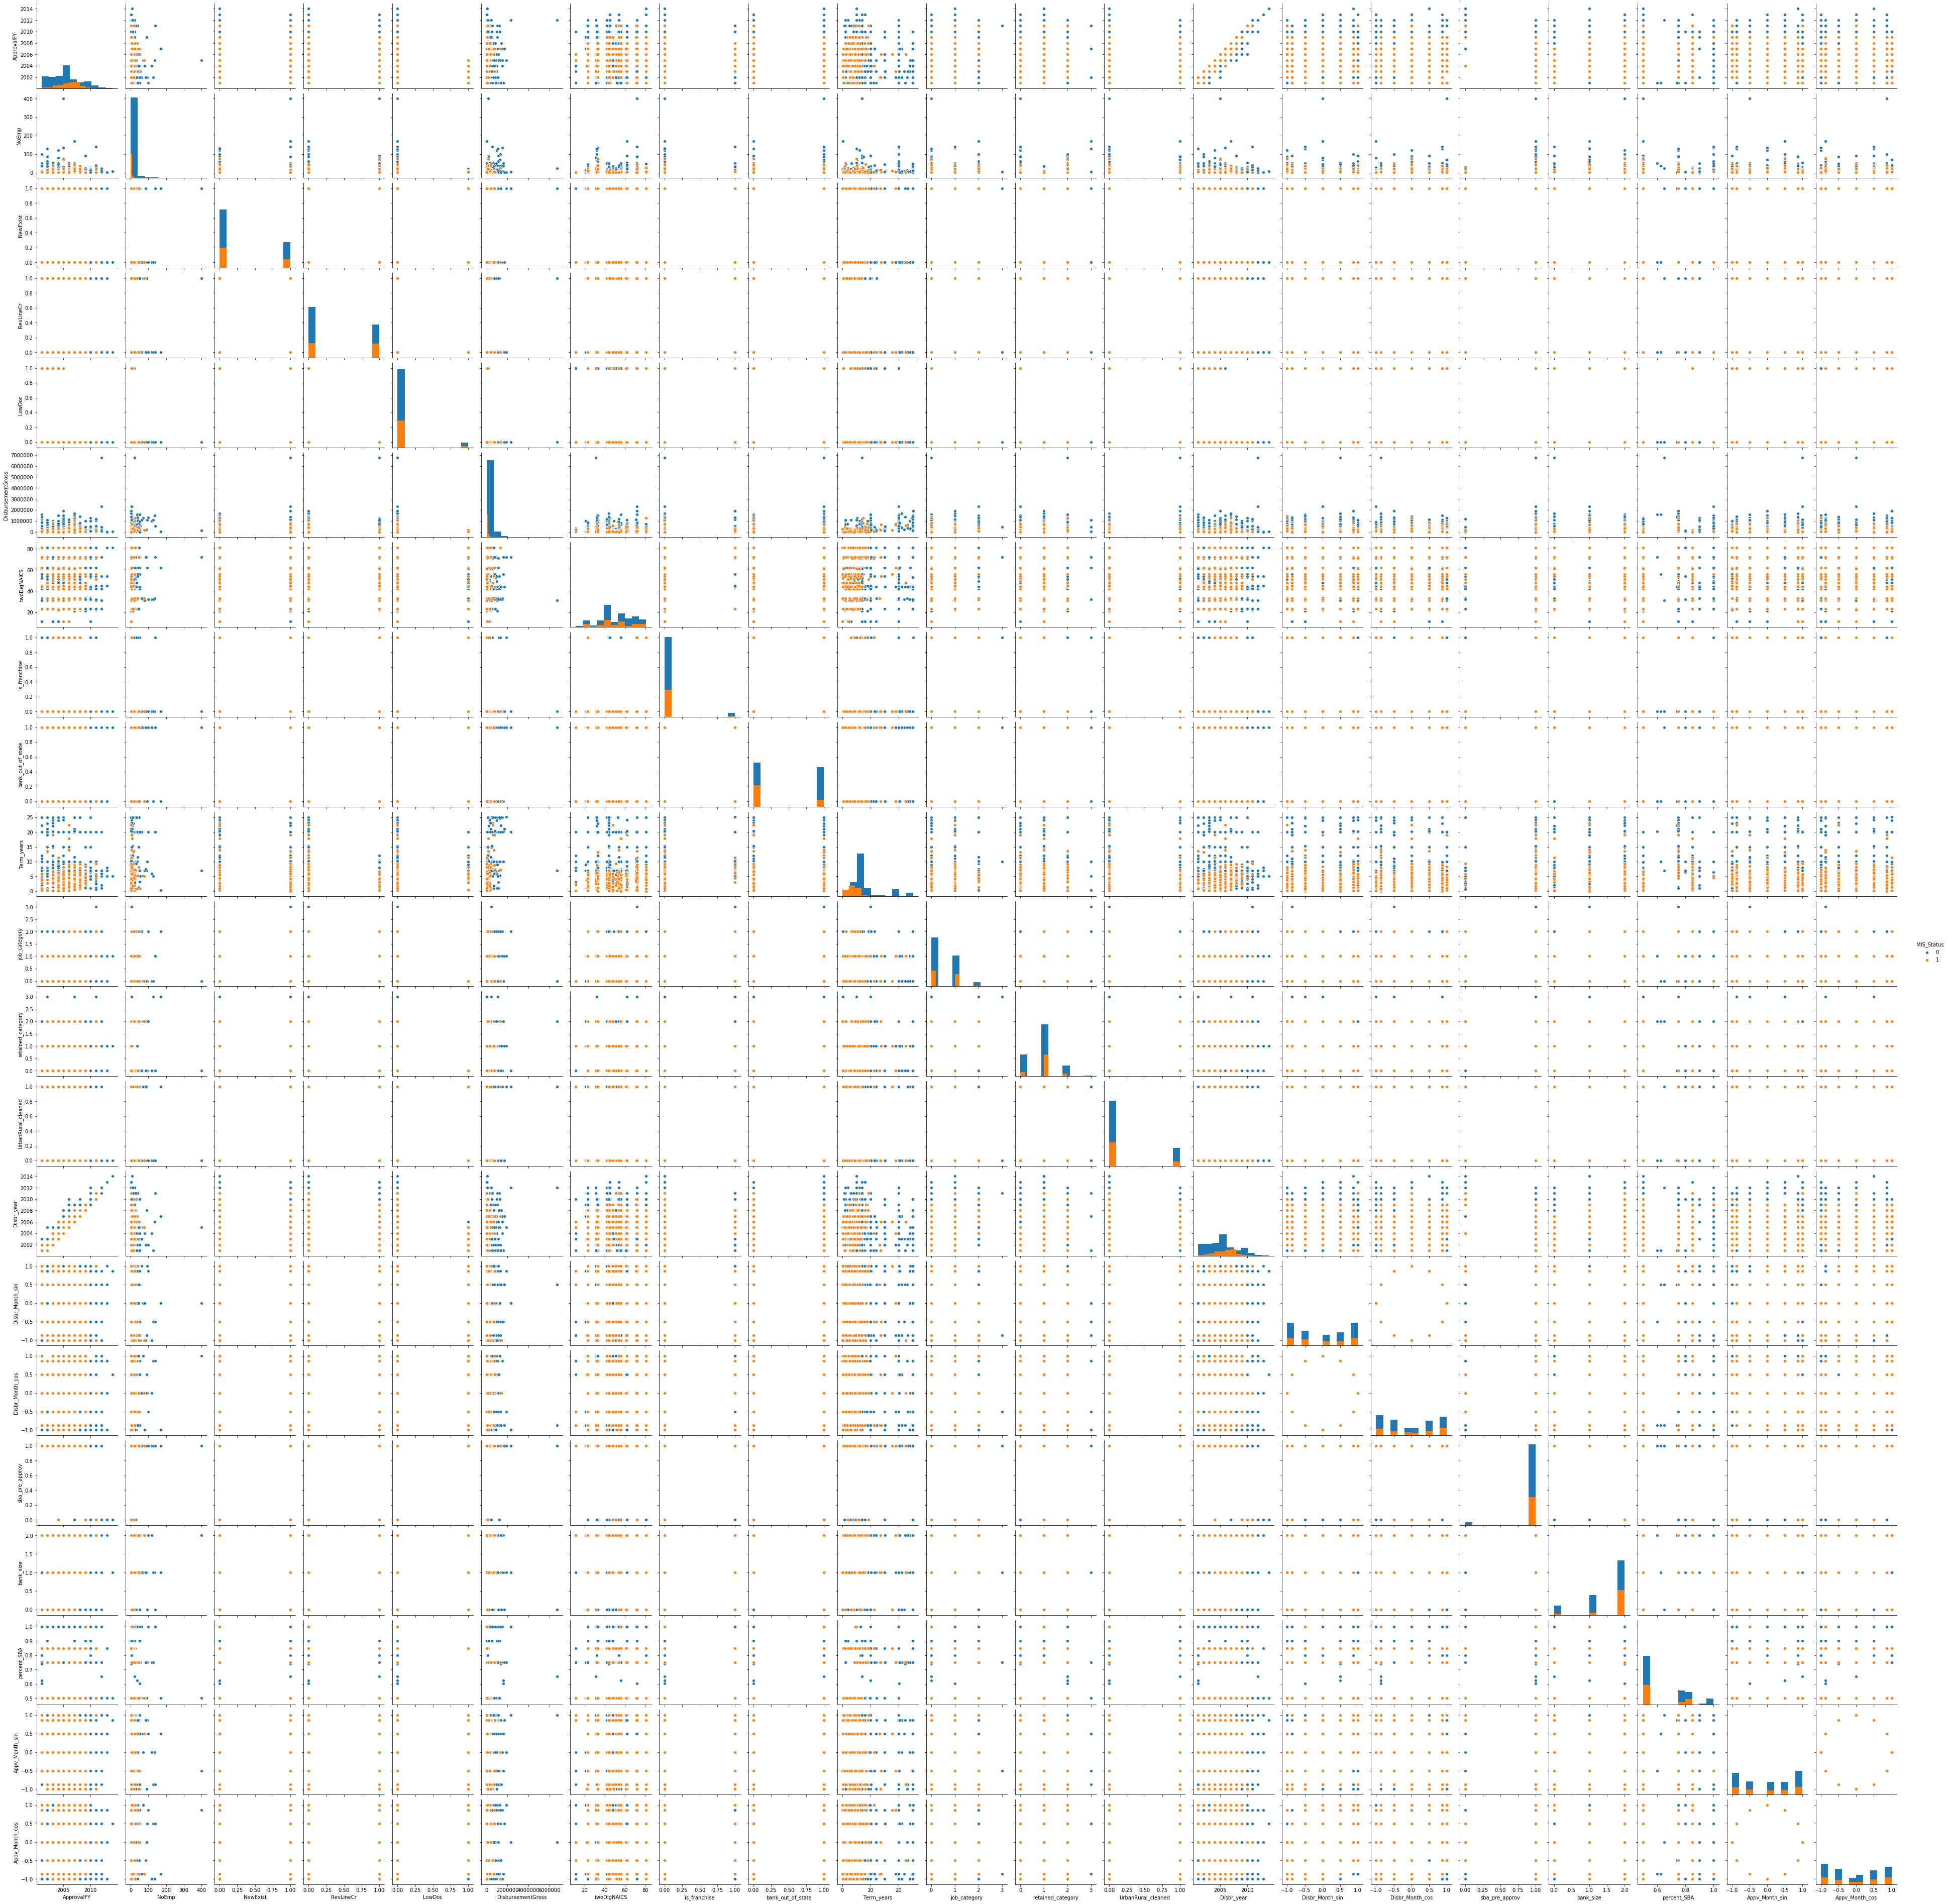

<IPython.core.display.Javascript object>

In [48]:
sns.pairplot(
    loans.select_dtypes(include="number").sample(1000),
    hue="MIS_Status",
    diag_kind="hist",
)

In [49]:
X = loans.drop(columns="MIS_Status")
y = loans["MIS_Status"]

<IPython.core.display.Javascript object>

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522582 entries, 12 to 894832
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   State               522582 non-null  object 
 1   BankState           522582 non-null  object 
 2   ApprovalFY          522582 non-null  int32  
 3   NoEmp               522582 non-null  int64  
 4   NewExist            522582 non-null  int64  
 5   RevLineCr           522049 non-null  float64
 6   LowDoc              518370 non-null  float64
 7   DisbursementGross   522582 non-null  float64
 8   twoDigNAICS         522582 non-null  int32  
 9   is_franchise        522582 non-null  float64
 10  bank_out_of_state   522582 non-null  int32  
 11  Term_years          522582 non-null  float64
 12  job_category        522582 non-null  float64
 13  retained_category   522582 non-null  float64
 14  UrbanRural_cleaned  516078 non-null  float64
 15  Disbr_year          522582 non-nu

<IPython.core.display.Javascript object>

In [51]:
loans.to_csv("sba_loans_cleaned2.csv", index=False)

<IPython.core.display.Javascript object>

In [80]:
len(loans["BankState"].value_counts())

51

<IPython.core.display.Javascript object>

In [81]:
loans.isna().sum()

State                    0
BankState                0
ApprovalFY               0
NoEmp                    0
NewExist                 0
RevLineCr              533
LowDoc                4212
DisbursementGross        0
MIS_Status               0
twoDigNAICS              0
is_franchise             0
bank_out_of_state        0
Term_years               0
job_category             0
retained_category        0
UrbanRural_cleaned    6504
Disbr_year               0
Disbr_Month_sin          0
Disbr_Month_cos          0
sba_pre_approv           0
bank_size                0
percent_SBA              0
Appv_Month_sin           0
Appv_Month_cos           0
dtype: int64

<IPython.core.display.Javascript object>

In [84]:
loans["ApprovalFY"].unique()

array([2006, 2001, 2003, 2004, 2005, 2007, 2008, 2009, 2010, 2011, 2002,
       2012, 2013, 2014])

<IPython.core.display.Javascript object>

##### On the fly EDA

In [86]:
data = pd.read_csv("data/SBAnational.csv")

<IPython.core.display.Javascript object>

In [93]:
data["ApprovalFY"].unique()

array([1997, 1980, 2006, 1998, 1999, 2000, 2001, 1972, 2003, 2004, 1978,
       1979, 1981, 2005, 1962, 1982, 1965, 1966, 1983, 1973, 1984, 2007,
       1985, 1986, 1987, 2008, 1988, 2009, 1989, 1991, 1990, 1974, 2010,
       1967, 2011, 1992, 1993, 2002, 2012, 2013, 1994, 2014, 1975, 1977,
       1976, 1968, '2004', '1994', '1979', '1976', '1967', '1975', '1974',
       '1977', '1981', '1982', '1983', '1984', '1978', '1980', '1968',
       '1976A', '1969', '1995', '1970', '2005', '1996', '1971', 1996,
       1971], dtype=object)

<IPython.core.display.Javascript object>

In [95]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522582 entries, 12 to 894832
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   State               522582 non-null  object 
 1   BankState           522582 non-null  object 
 2   ApprovalFY          522582 non-null  int32  
 3   NoEmp               522582 non-null  int64  
 4   NewExist            522582 non-null  int64  
 5   RevLineCr           522049 non-null  float64
 6   LowDoc              518370 non-null  float64
 7   DisbursementGross   522582 non-null  float64
 8   MIS_Status          522582 non-null  int64  
 9   twoDigNAICS         522582 non-null  int32  
 10  is_franchise        522582 non-null  float64
 11  bank_out_of_state   522582 non-null  int32  
 12  Term_years          522582 non-null  float64
 13  job_category        522582 non-null  float64
 14  retained_category   522582 non-null  float64
 15  UrbanRural_cleaned  516078 non-nu

<IPython.core.display.Javascript object>